<a href="https://colab.research.google.com/github/TomYOON/Stock-project/blob/master/finanace_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#ticker ="140410"
input_value = [0,1,2,3,4]

# **함수 선언부**

In [0]:
class LSTM_sequential(nn.Module):   
  def __init__(self, input_size, hidden, drop, num_layer=1):
    super().__init__()
    self.num_layers = num_layer
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden,num_layers = self.num_layers, dropout = drop)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = 1)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden[self.num_layers-1,:,:].squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

#str 변환시 함수 이름이 출력되게함
  def __str__(self):
    return str(LSTM_sequential).split(".")[1][:-2]

In [0]:
def call_model(model,time_steps,ticker, num_layer=1, hidden_layer=10):
  model = LSTM_sequential(input_size, hidden, dropout_rate, num_layer)
  model = model.to(device)
  model = model.double() 

  path_dir = "/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/"
  pretrained_model_list = os.listdir(path_dir)
  pretrained_model_list.sort()   #가장 loss가 낮은 모델을 부르기 위해 정렬 #저장양식 model_name + "-loss_"+str(int(loss*1000)) ex LSTM_sequential_loss_1 #모델/loss 구분 "-"(하이푼)
  i = 0
  model_state = model.state_dict()
  pre_train_loss = 1
  #foresee_date = model_state["foresee_date"]
  for trained_model in pretrained_model_list:
    i+=1
    if str(model) == trained_model.split("-")[0] and num_layer == int(trained_model.split("-")[1]) \
    and hidden_layer == int(trained_model.split("-")[2]) and str(time_steps)==trained_model.split("-")[3] and ticker ==trained_model.split("-")[4]:
      model_state_dict = torch.load(path_dir+"/"+trained_model)
      model_state = model_state_dict["model_state"]
      model.load_state_dict(model_state)
      print("불러온 모델:", trained_model)
      break
    if i == len(pretrained_model_list):
      print("저장된 같은 모델이 없습니다")
      model_state_dict = {"model_state":model.state_dict(),
                      "loss":train_loss,
                      "lr": lr,
                      "hidden_layer": hidden_layer,
                      "num_layers" : num_layer,
                      "time_step":time_steps,
                      "foresee_date":1
                      }
  
  
  return model, model_state_dict




In [0]:
def prediction_df(df,foresee_date,model,model_state_dict, input_size=5):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  criterion = nn.MSELoss()
  criterion = criterion.to(device)
  lr = model_state_dict["lr"]
 
  epoch = 50
  batch_size = 5
  dropout_rate = 0.3
  hidden = model_state_dict["hidden_layer"]
  foresee_date = 1
  
  csv_np_raw = df.to_numpy()
  row,col = np.shape(csv_np_raw)

  full_data_np = csv_np_raw[:,:]
  data_np = full_data_np[:,input_value]
  scaler = MinMaxScaler()
  scaler.fit(data_np)
  data_norm = scaler.transform(data_np)
  data_norm = np.insert(data_norm,0,np.arange(data_norm.shape[0]),axis=1)

  
  data_val_tensor = torch.from_numpy(np.expand_dims(data_norm, axis=1)).to(device)
  
  target_val_np = data_norm[time_steps:,[0,3]]
  target_val_tensor = torch.from_numpy(np.expand_dims(target_val_np, axis=0)).to(device)
  
  loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)
  
  view_plot(predictions_val, target_val_np)
  print(time_steps)
  return predictions_val, target_val_np

In [0]:
def evaluate(time_steps, date, data, target, model, criterion):
  epoch_loss = 0
  epoch_acc = 0
  predictions=[]
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()
  num_tries = list(target.size())[1] - (date - 1)
  
  with torch.no_grad():
    for i in range(num_tries):

      starting_date = data[i:i+time_steps,:,:][-1,0,0].item()

      input_data = data[i:i+time_steps,:,1:]

      all_predictions = []

      for d in range(date):
        prediction = model(input_data)
        all_predictions.append(prediction)
        data_last = input_data[-1:,:,:].clone()
        data_last[0,0,1] = prediction.item()

        input_data = torch.cat((input_data[1:,:,:],data_last),axis=0)

      
      total_prediction = torch.tensor(all_predictions).to(device)
      
      timestamps = torch.from_numpy(np.arange(date) + starting_date + 1).to(device).view(date,1)
      
      prediction_with_time = torch.cat([timestamps,total_prediction.view(date,1)],axis=1)
      
      predictions.append(prediction_with_time.tolist())
      loss = criterion(torch.squeeze(target)[i:i+date,1],torch.squeeze(total_prediction))

      epoch_loss += loss.item()
    
  return epoch_loss/num_tries, np.array(predictions)

In [0]:
def view_plot(prediction_list, target_list):
  fig = plt.figure(figsize=(20, 20))
  lenth = len(prediction_list)
  if lenth > 1000:
    step = lenth // 10
  else:
    step = 100

  num_graph = lenth//step
  ax = []
  for i in range(num_graph):
    ax.append(fig.add_subplot(num_graph,1,i+1)) 

  
  for i in range(1,num_graph+1):
    start = (i-1) * step

    if i == 7: end = prediction_list.shape[0]
    else: end = i * step

  # try:
    ax[i-1].plot(target_list[0:,0][start:end],target_list[0:,1][start:end])
    ax[i-1].plot(prediction_list[:,0,0][start:end],prediction_list[:,0,1][start:end])
    for j in range(start, end):
      if j%foresee_date == 0:
        ax[i-1].plot(prediction_list[:,:,0][j],prediction_list[:,:,1][j], color = 'b')

In [8]:
pip install finance-datareader

In [0]:
def replace_nan(df):
  columns = df.columns[1:]
  print(columns)
  for col in columns:
    index = df[df[col].isna()][col].index
    for i in index:
      pre = i-1
      af = i+1
   
      while(pre in index):
        pre = -1
      while(af in index):
        af +=1
      if pre <0:
        pre = df.mean()[col]
      if af > df.shape[0]:
        df.mean()[col]
      input_value = (df[col][pre] + df[col][af]) / 2
      df[col][i] = input_value
  return df

In [0]:
def make_signal(prediction_val):
  print("len(prediction_val):", len(prediction_val))
  pre_value = prediction_val[0:,0,1][0]
  signal = [0]
  for i in range(1,len(prediction_val[0:,0,1])):      
    if pre_value  < prediction_val[0:,0,1][i]:
      signal.append(1)    
    else:
      signal.append(0)
    pre_value = prediction_val[0:,0,1][i]
  tommorrow = signal.pop(-1)
  print(signal)
  print("lenth of signal:",len(signal))
  print("lenth of prediction_val:", len(prediction_val[0:,0,1]))
  return signal, tommorrow

In [0]:
def check_return(csv_df, prediction_val,time_steps, signal):
  df = pd.DataFrame()
  df["Close"] = csv_df["Close"][time_steps:]
  df["change"] = (csv_df['Close'] - csv_df['Close'].shift(1)) / csv_df['Close']
  df["next"] = df['Close'].shift(-1)

  df = df.dropna()
  y = np.where(df["next"]>df["Close"],1,0)
  df['O-C'] = csv_df["Open"] - csv_df["Close"]
  df['H-L'] = csv_df["High"] - csv_df['Low']
  df
  X = df[['O-C','H-L']]
  X.head()
  print("df.shape[0]:",df.shape[0])
  df["signal"] = signal
  df["return"] = np.log(df["next"]/df["Close"])
  df["Strategy_Return"] = df['signal']*df['return']
  return df

In [0]:
import FinanceDataReader as fdr

# **모델 실제 예측**
ticker를 기준으로 그 ticker에 맞게 학습된 모델이 불려옴
만약 다른 ticker로 학습시킨 모델로 다른 종목을 평가하려면
아래의 ticker변수에는 학습시킨 모델 ticker를 입력하고
fdr.DataReader에는 바로 번호를 입력하면
ticker변수에 있는 모델로 바로 번호입력한 종목을 평가 할 수 있음

In [173]:
ticker = "140410" #train된 모델 티커
Df = fdr.DataReader(ticker,'2015','2019-12-04') #여기는 불러올 종목
print(Df.shape)
Df.head()
Df

(1210, 6)


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2015-01-02,34650,35650,34050,35100,24023,-0.002841
2015-01-05,34500,37200,34250,36450,46402,0.038462
2015-01-06,35850,38400,35850,38400,50016,0.053498
2015-01-07,38400,39650,37950,38400,26991,0.000000
2015-01-08,39250,39250,36900,37950,37697,-0.011719
...,...,...,...,...,...,...
2019-11-28,144000,144800,136400,139100,214218,-0.045953
2019-11-29,138300,141700,135500,139800,195135,0.005032
2019-12-02,142100,147800,140300,145500,234714,0.040773


In [174]:
Df = replace_nan(Df)

Index(['High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')


불러온 모델: LSTM_sequential-1-10-20-140410-loss_1.pt


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


20
lenth of prediction_val: 1190


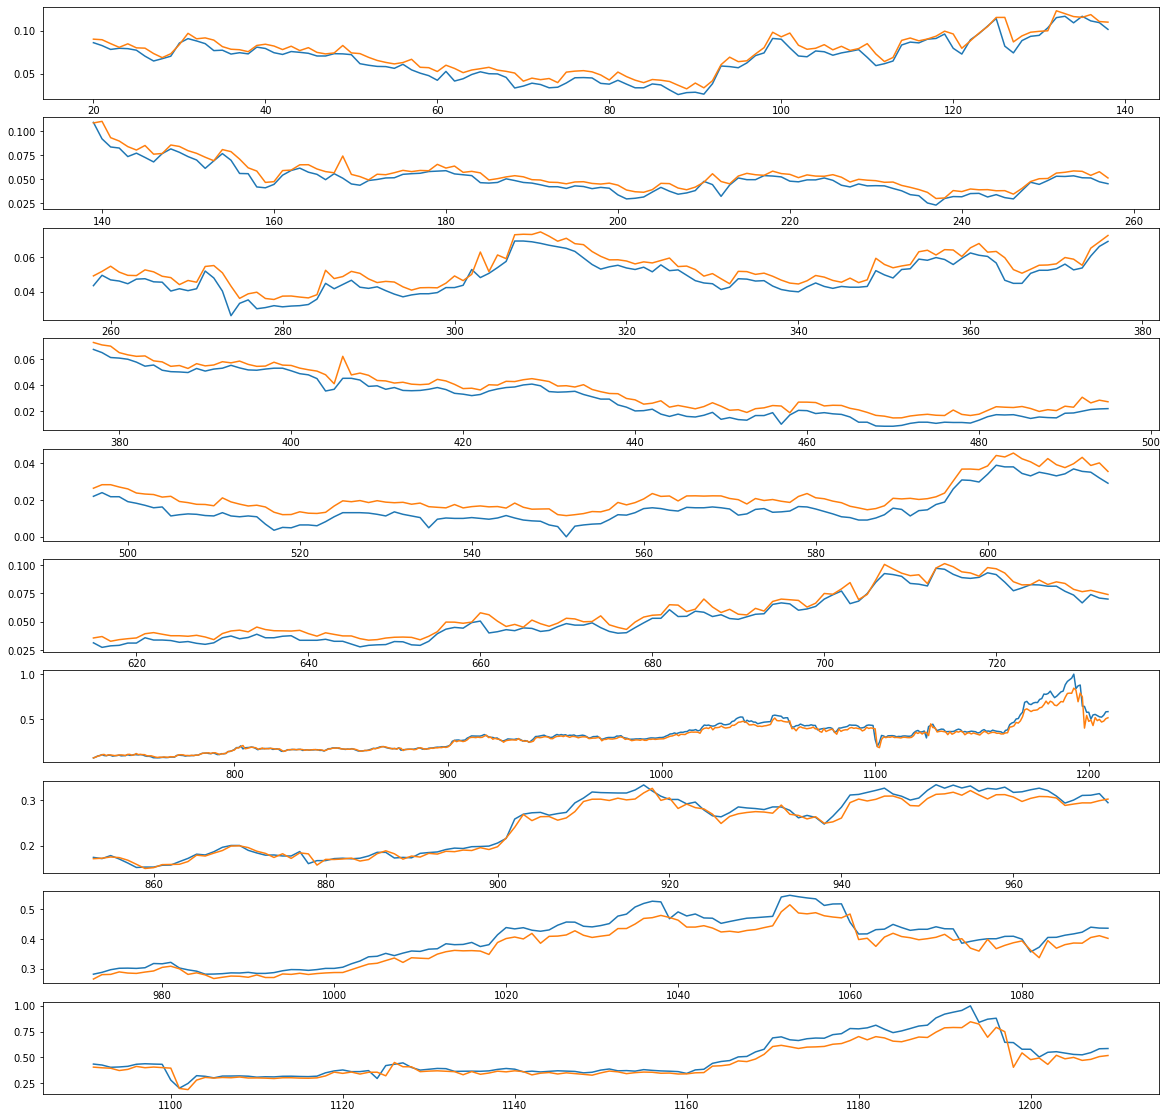

In [175]:
#print(time_steps)
model, model_state_dict = call_model(model,time_steps,ticker, num_layer=1, hidden_layer=10)
#print(model_state_dict)
prediction_val,_ = prediction_df(Df,foresee_date,model,model_state_dict, input_size=5)
print("lenth of prediction_val:",len(prediction_val))

In [176]:
len(prediction_val)

1190

len(prediction_val): 1190
[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0

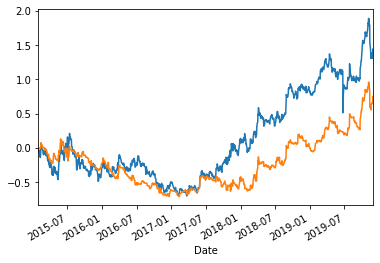

In [185]:
def model_prediction(df,prediction_val):
  signal, tommorrow = make_signal(prediction_val)
  re = check_return(df, prediction_val, time_steps,signal)
  print("일반수익률:",re["return"].cumsum().values[-1])
  print("모델수익률:",re["Strategy_Return"].cumsum().values[-1])
  re["return"].cumsum().plot()
  re["Strategy_Return"].cumsum().plot()
  comment = "내려갑니다."
  if tommorrow == 1:
    comment = "오릅니다."
  
  print("내일은",comment )
model_prediction(Df,prediction_val)

# **모델 학습 부분**

In [0]:
def train(time_steps, date, data_target_batches, model, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  #prediction_list=[]
  batch_amount = len(data_target_batches)
  batch_size = list(data_target_batches[0][0].size())[1]
  model.train()
  
  for data, target in data_target_batches:
    
    assert target[0,0,0].item() == (data[-1,0,0].item() + 1)
    
    optimizer.zero_grad()   
    
    data_without_timestamp = data[:,:,1:].clone()

    all_predictions = []
    
    for d in range(date):
      prediction_batch = model(data_without_timestamp)
      all_predictions.append(prediction_batch)
      data_last = data_without_timestamp[-1:,:,:].clone()
      for b in range(batch_size):
        data_last[0,b,1] = prediction_batch[b].item()  


      data_without_timestamp = torch.cat((data_without_timestamp[1:,:,:],data_last),axis=0)

    target_without_timestamp = torch.squeeze(target[:,:,1])
    loss = criterion(torch.squeeze(target_without_timestamp), torch.squeeze(torch.cat(all_predictions,axis=1)))
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  
  return epoch_loss / batch_amount

In [0]:
def data_preprocessing(data_norm,time_steps, foresee_date, slice_point = 800):
  #slice_point = 800
  data_train_np = data_norm[:slice_point,:]
  data_val_np = data_norm[slice_point:,:]
  data_train_tensor = torch.from_numpy(np.expand_dims(data_train_np, axis=1)).to(device)
  data_val_tensor = torch.from_numpy(np.expand_dims(data_val_np, axis=1)).to(device)

  target_train_np = data_train_np[time_steps:,[0,3]]

  target_train_tensor = torch.from_numpy(np.expand_dims(target_train_np, axis=0)).to(device)
  target_val_np = data_val_np[time_steps:,[0,3]]
  target_val_tensor = torch.from_numpy(np.expand_dims(target_val_np, axis=0)).to(device)

  train_batches = []

  for i in range((slice_point - time_steps - (foresee_date - 1)) // batch_size):
    data_batch = []
    train_batch = []
    for b in range(batch_size):
      data_batch.append(data_train_tensor[i*batch_size + b:i*batch_size + b + time_steps,:,:])
      train_batch.append(target_train_tensor[:,i*batch_size + b:i*batch_size + b + foresee_date])
      
    train_batches.append((torch.cat(data_batch,axis=1),torch.cat(train_batch,axis=0)))

  return data_train_np, data_val_np, target_train_np, target_val_np, train_batches ,data_batch, data_val_tensor, data_train_tensor,target_train_tensor,target_val_tensor

In [0]:
ticker = "140410"

df = fdr.DataReader(ticker,'2015','2019-12-04')
#Open	High	Low	Close	Volume
#0     1     2    3    4
input_value = [0,1,2,3,4]

full_data_np = df.to_numpy()
row,col = np.shape(full_data_np)

training_point = 1120
data_np = full_data_np[:training_point,input_value] 
scaler = MinMaxScaler()
scaler.fit(data_np)
data_norm = scaler.transform(data_np)
#print(data_norm)
data_norm = np.insert(data_norm,0,np.arange(data_norm.shape[0]),axis=1)

**hyper parameters**

In [0]:
lr = 0.0005
time_steps = 20
epoch = 50
batch_size = 5
dropout_rate = 0.3
num_layers = 1
input_size = data_np.shape[1] #open close high low volume
#hidden1 = 100
hidden = 10
#fc = 15
num_layer =1 
pre_train_loss = 1
foresee_date = 1
shuffle = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [182]:
  model = LSTM_sequential(input_size, hidden, dropout_rate, num_layer)
  model = model.to(device)
  model = model.double() 
  model,_ = call_model(model, time_steps,ticker)

불러온 모델: LSTM_sequential-1-10-20-140410-loss_1.pt


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [183]:
####################################################
slice_point = 800

optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.MSELoss()
criterion = criterion.to(device)
data_train_np, data_val_np, target_train_np, target_val_np, train_batches ,data_batch, data_val_tensor, data_train_tensor,target_train_tensor,target_val_tensor = data_preprocessing(data_norm, time_steps,foresee_date,slice_point)
dir = "/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = data_np.shape[1]
  
if shuffle:
  random.shuffle(train_batches)
  for ep in range(1000):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    start_time = time.time()
    train_loss = train(time_steps, foresee_date, train_batches, model, optimizer, criterion)
    end_time = time.time()
    if ep%10 == 0:
      print(train_loss)
      print(end_time - start_time)
      if train_loss < pre_train_loss and train_loss < 0.003:      #이전보다 loss가 낮으면 저장함.
        
        pre_train_loss = train_loss           #제일 낮은 loss 갱신
        if not os.path.exists(dir):
          os.makedirs(dir)          #dir가 없으면 만들어서 저장
        save_dict = {"model_state":model.state_dict(),
                      "loss":train_loss,
                      "lr": lr,
                      "optimizer": optimizer,
                      "hidden_layer": hidden,
                      "num_layers" : num_layer,
                      "time_step":time_steps,
                      "foresee_date":foresee_date,
                      "criterion":criterion,
                      "input_value":input_value}
        model_name = dir+str(model)+"-"+str(num_layer)+'-'+str(hidden)+"-"+str(time_steps)+"-"+ticker+'-loss_'+str(int(train_loss*10000))+".pt"   #여러명이 돌릴경우 직관성을 위해 filename에 loss도 포함
        torch.save(save_dict,model_name)
        print("save",model_name)
        lr *= 0.9
loss_train, predictions_train = evaluate(time_steps, foresee_date, data_train_tensor, target_train_tensor, model, criterion)
view_plot(predictions_train, target_train_np)
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)
view_plot_val(predictions_val, target_val_np)


  

0.00016313586351533
0.4826221466064453
save /content/gdrive/My Drive/Colab Notebooks/stock_project/Models/LSTM_sequential-1-10-20-140410-loss_1.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MSELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


KeyboardInterrupt: ignored